# Training and Testing

Now that we performed all necessary pre processing steps, we can start with the modelling process. We will use XGBoost, which is a regularizing gradient boosting framework (see: https://xgboost.readthedocs.io/en/stable/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('fivethirtyeight')

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
data=pd.read_csv('/Users/lutz/Documents/911_data/data/combined_data_20221010.csv')
data['Datetime']=pd.to_datetime(data['Datetime'])
data = data.set_index('Datetime')
data = data.sort_index()
data

,counts,dayofweek,dayofyear,month,weekofyear,season,lag_year,lag_month,lag_week,lag_day,TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches)
Datetime,,,,,,,,,,,,,
2003-11-08,254,5,312,11,45,3,NaN,NaN,NaN,199.0,57.0,45.0,0.00
2003-11-09,240,6,313,11,45,3,NaN,NaN,NaN,254.0,52.0,41.0,0.00
2003-11-10,239,0,314,11,46,3,NaN,NaN,NaN,240.0,53.0,40.0,0.03
2003-11-11,179,1,315,11,46,3,NaN,NaN,NaN,239.0,56.0,40.0,0.00
2003-11-12,215,2,316,11,46,3,NaN,NaN,NaN,179.0,56.0,37.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27,361,1,270,9,39,3,284.0,341.0,352.0,375.0,79.0,52.0,0.00
2022-09-28,349,2,271,9,39,3,275.0,341.0,351.0,361.0,67.0,55.0,0.03
2022-09-29,364,3,272,9,39,3,301.0,316.0,350.0,349.0,72.0,54.0,0.00


Now we do the train-test split at the mark of 80%.


In [4]:
split_date=str(data.index[round(len(data.index)*0.8)])
train_data=data.loc[data.index <= split_date].copy()
test_data=data.loc[data.index > split_date].copy()

Now we visualize the train and test data

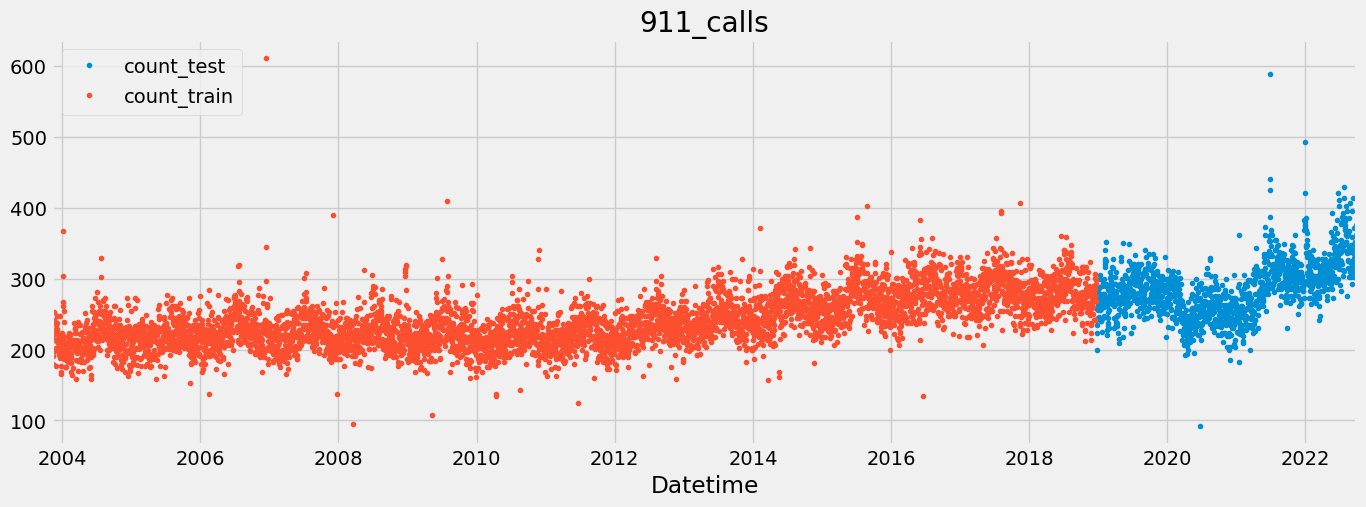

In [5]:
plot_test = test_data[['counts']]
plot_test=plot_test.rename(columns={'counts':'count_test'}) 

plot_train = train_data[['counts']]
plot_train=plot_train.rename(columns={'counts':'count_train'}) 

plot_test.join(plot_train, how='outer').plot(figsize=(15,5), title='911_calls', style='.')
plt.show()

Now we are performing the data split for the cross-validation and visualizing it

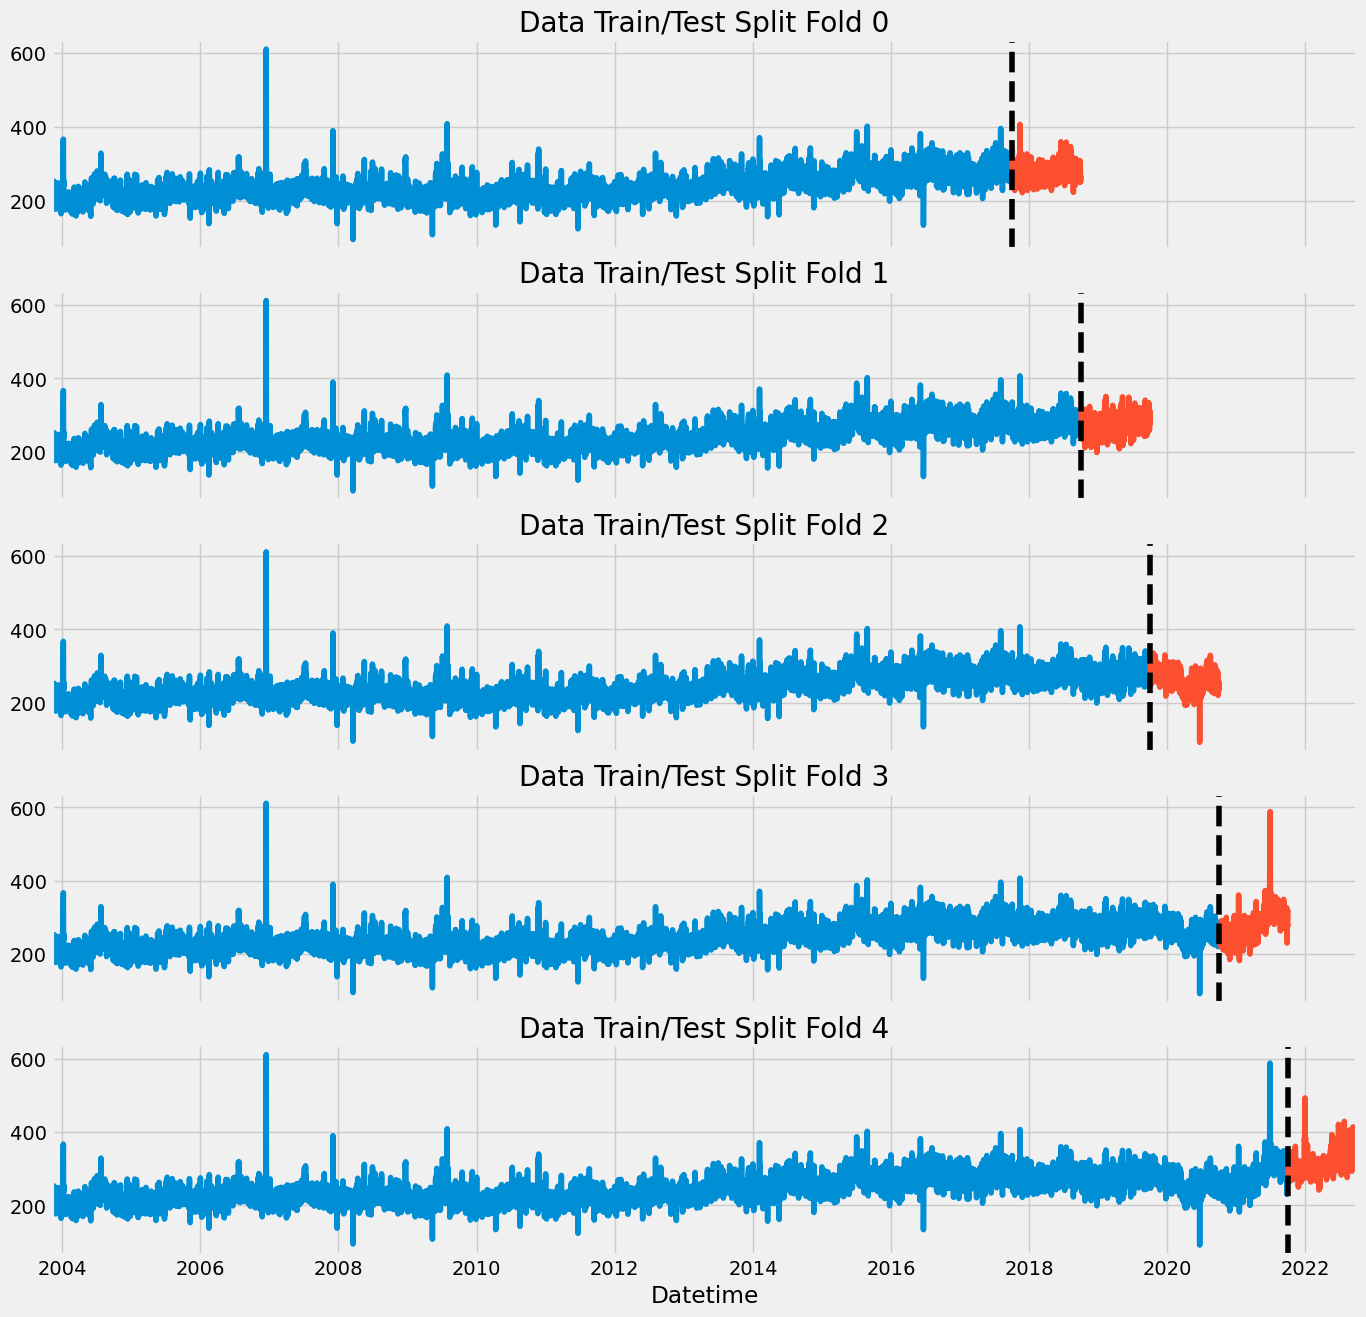

In [6]:
tss=TimeSeriesSplit(n_splits=5, test_size=365)
fig, axs=plt.subplots(5,1, figsize=(15,15),
                           sharex=True)

fold=0

for train_idx, val_idx in tss.split(data):
    train=data.iloc[train_idx]
    test=data.iloc[val_idx]
    train['counts'].plot(ax=axs[fold],
                         label='Traing Set',
                         title=f'Data Train/Test Split Fold {fold}')
    test['counts'].plot(ax=axs[fold],
                         label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='k', ls='--')
    fold+=1
plt.show()

Now we start the training with some initial values for the hyperparameters. We perform it using cross-validation. 

In [7]:
tss = TimeSeriesSplit(n_splits=5, test_size=28)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]



    FEATURES = ['dayofweek', 'dayofyear', 'month', 'weekofyear', 'season','TMAX (Degrees Fahrenheit)',
                'TMIN (Degrees Fahrenheit)','PRCP (Inches)', 'lag_year', 'lag_month', 'lag_week', 'lag_day']
    
    TARGET = 'counts'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(n_estimators=1000, 
                       learning_rate=0.05, 
                       max_depth = 6,
                       reg_lambda = 10,
                       reg_alpha= 10,
                       subsample=0.9,
                       early_stopping_rounds=50,
                       colsample_bytree = 0.5, 
                       seed=20)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:237.72606	validation_1-rmse:316.02648
[100]	validation_0-rmse:22.04276	validation_1-rmse:38.77387
[200]	validation_0-rmse:20.25935	validation_1-rmse:35.82291
[229]	validation_0-rmse:19.97176	validation_1-rmse:35.81982
[0]	validation_0-rmse:238.08909	validation_1-rmse:324.15807
[100]	validation_0-rmse:22.01574	validation_1-rmse:36.06608
[200]	validation_0-rmse:20.36433	validation_1-rmse:29.75484
[300]	validation_0-rmse:19.28454	validation_1-rmse:29.05382
[400]	validation_0-rmse:18.20336	validation_1-rmse:28.63936
[474]	validation_0-rmse:17.27680	validation_1-rmse:28.78513
[0]	validation_0-rmse:238.49116	validation_1-rmse:346.09796
[100]	validation_0-rmse:21.99223	validation_1-rmse:41.18575
[200]	validation_0-rmse:20.35674	validation_1-rmse:36.56765
[283]	validation_0-rmse:19.49844	validation_1-rmse:36.69638
[0]	validation_0-rmse:239.01070	validation_1-rmse:328.20899
[100]	validation_0-rmse:22.02094	validation_1-rmse:34.47754
[200]	validation_0-rmse:20.40346	validat

In [8]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 32.5761
Fold scores:[35.75471362107155, 28.533304949317415, 36.257286095633795, 31.335534475274137, 30.99986851386081]


This looks already promising. Let's do a grid search for hyperparameter tuning.

In [9]:
params = { 'max_depth': [2,3,4],
           'learning_rate': [0.1, 0.05, 0.01],
           'n_estimators': [500],
           'reg_alpha' : [10, 100, 200], 
           'reg_lambda' : [0.1, 1, 10],
           'colsample_bytree': [0.5],
           'subsample':[0.9],
           'min_child_weight' : [0.1,1, 10],
           'gamma' : [0, 0.01, 0.1]
           
           }


xgbr = xgb.XGBRegressor(seed=20)

clf = GridSearchCV(estimator=xgbr, param_grid=params,scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=True)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 500, 'reg_alpha': 100, 'reg_lambda': 1, 'subsample': 0.9}
Lowest RMSE:  24.37061233935771


Now we use these parameters to train the model again and visualize the predictions.

In [10]:
params={'colsample_bytree': 0.5,
        'gamma': 0,
        'learning_rate': 0.05,
        'max_depth': 3,
        'min_child_weight': 10,
        'n_estimators': 500,
        'reg_alpha': 100,
        'reg_lambda': 1,
        'subsample': 0.9,
        'early_stopping_rounds' : 50}

In [11]:
X_train=train_data.iloc[:,1:].astype('float')
y_train=train_data.iloc[:,0].astype('float')

X_test=test_data.iloc[:,1:].astype('float')
y_test=test_data.iloc[:,0].astype('float')


reg=xgb.XGBRegressor(**params, seed=20)


reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

[0]	validation_0-rmse:230.49153	validation_1-rmse:274.68529
[100]	validation_0-rmse:22.10574	validation_1-rmse:32.37197
[200]	validation_0-rmse:21.22523	validation_1-rmse:29.84570
[300]	validation_0-rmse:20.75140	validation_1-rmse:29.40918
[380]	validation_0-rmse:20.45848	validation_1-rmse:29.39463


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=20,
             reg_alpha=100, reg_lambda=1, ...)

Looks good. Now we can have a look at the predict vs. the real values. First we predict the Test Data and look at the mean absolute percentage error to get a better feeling how far we are off with our prediction. 

In [12]:
y_pred=reg.predict(X_test)
test_data['Count_Prediction'] = y_pred
all_counts = pd.concat([test_data, train_data], sort=False)

In [13]:
mape=mean_absolute_percentage_error(y_true=test_data['counts'], y_pred=test_data['Count_Prediction'])

print(f'On average, the prediction is off by {mape} %')


On average, the prediction is off by 7.7295485945398585 %


Looks good. Let's plot the data

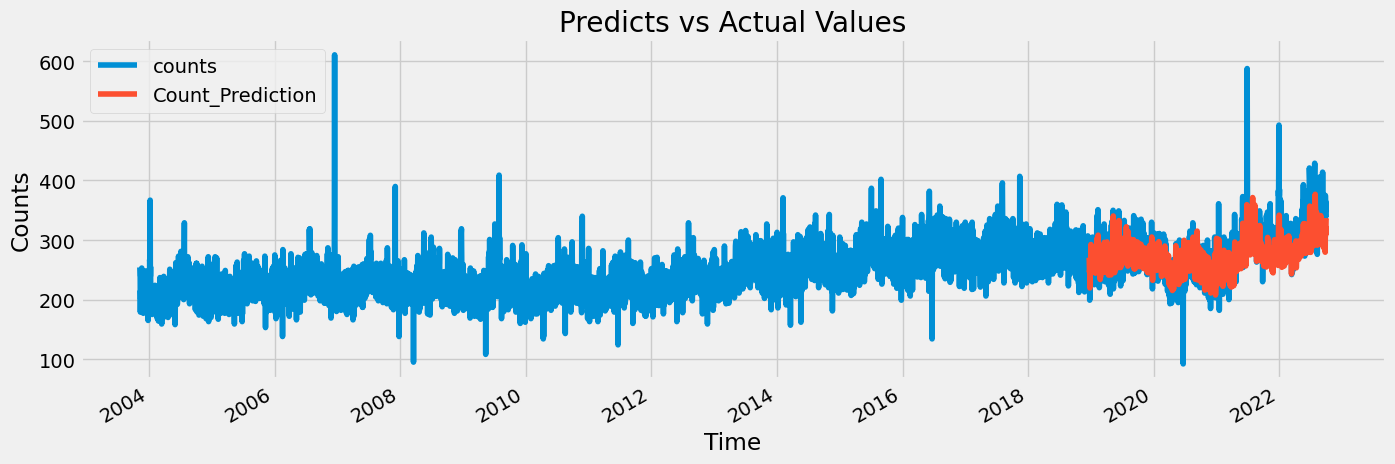

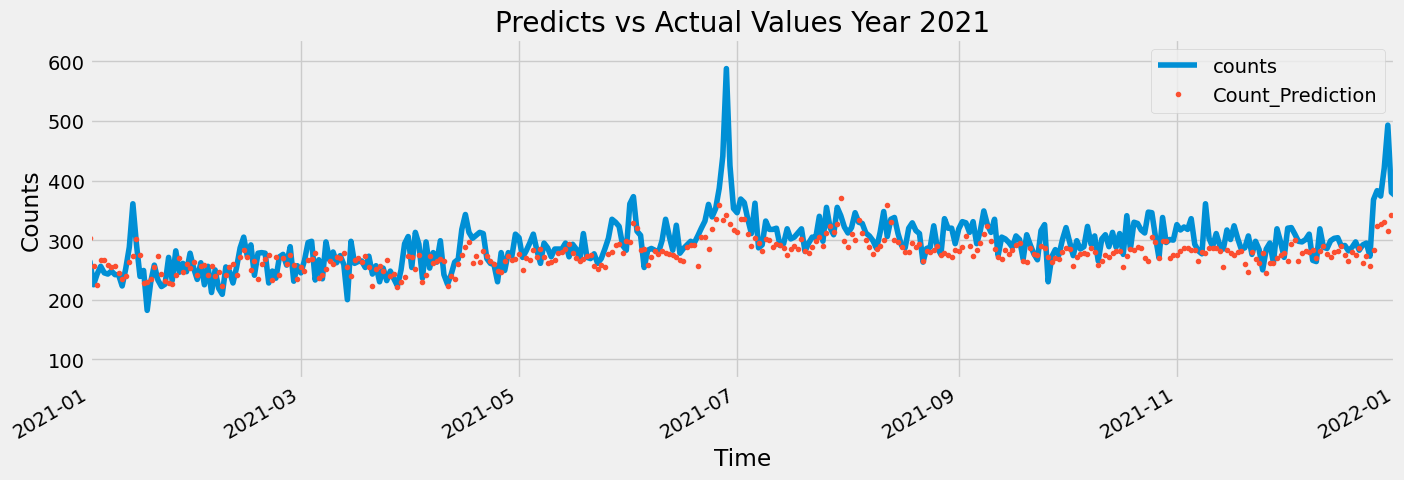

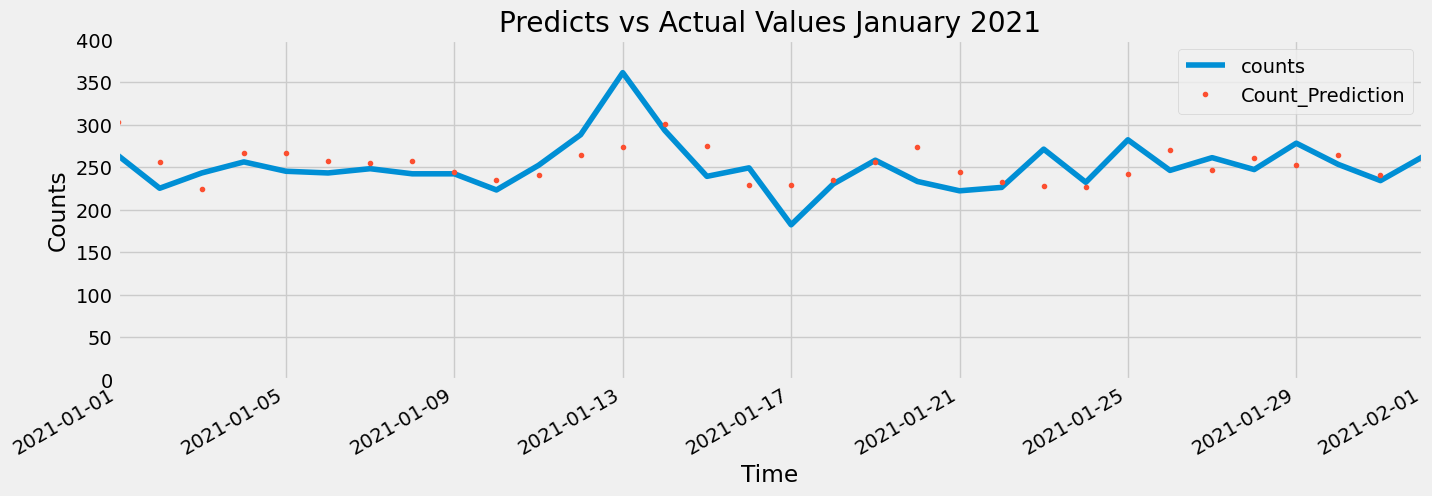

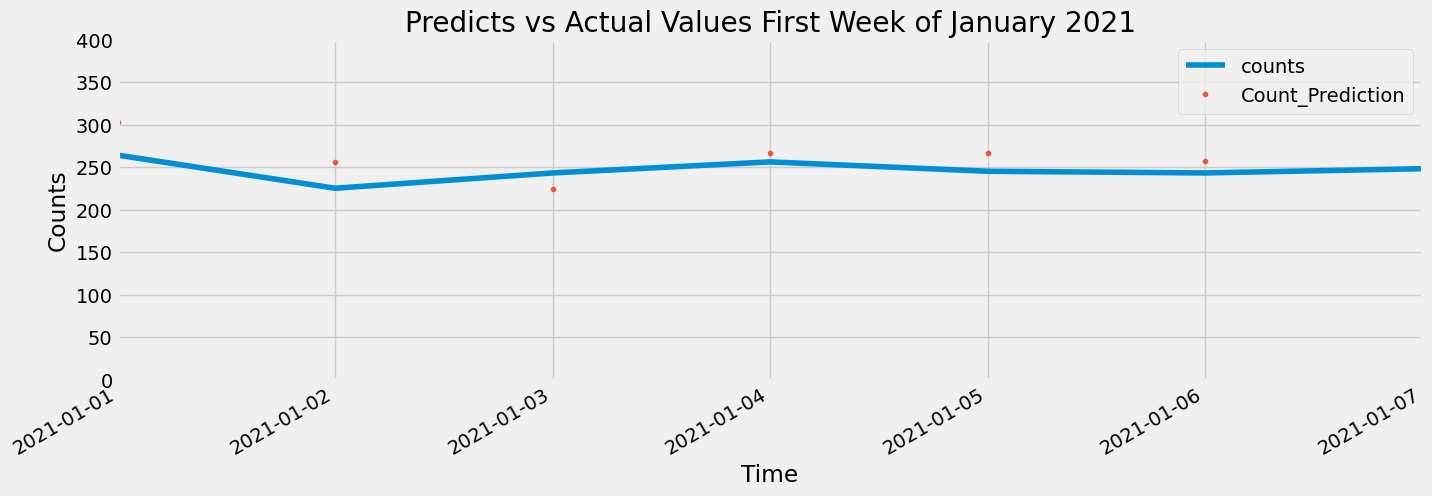

In [14]:
all_counts[['counts','Count_Prediction']].plot()
ax_1=plt.gca()
ax_1.set_title('Predicts vs Actual Values')
ax_1.set_xlabel('Time')
ax_1.set_ylabel('Counts')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

all_counts[['counts','Count_Prediction']].plot(style=['-','.'])
ax_1=plt.gca()
ax_1.set_title('Predicts vs Actual Values Year 2021')
ax_1.set_xbound(lower='2021-01-01', upper='2022-01-01')
ax_1.set_xlabel('Time')
ax_1.set_ylabel('Counts')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

all_counts[['counts','Count_Prediction']].plot(style=['-','.'])
ax_1=plt.gca()
ax_1.set_title('Predicts vs Actual Values January 2021')
ax_1.set_xbound(lower='2021-01-01', upper='2021-02-01')
ax_1.set_xlabel('Time')
ax_1.set_ylabel('Counts')
ax_1.set_ylim(0, 400)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()


all_counts[['counts','Count_Prediction']].plot(style=['-','.'])
ax_1=plt.gca()
ax_1.set_title('Predicts vs Actual Values First Week of January 2021')
ax_1.set_xbound(lower='2021-01-01', upper='2021-01-07')
ax_1.set_xlabel('Time')
ax_1.set_ylabel('Counts')
ax_1.set_ylim(0, 400)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()


Looks good. The model even picks up on smaller trends. Now let's have a look at the feature importance

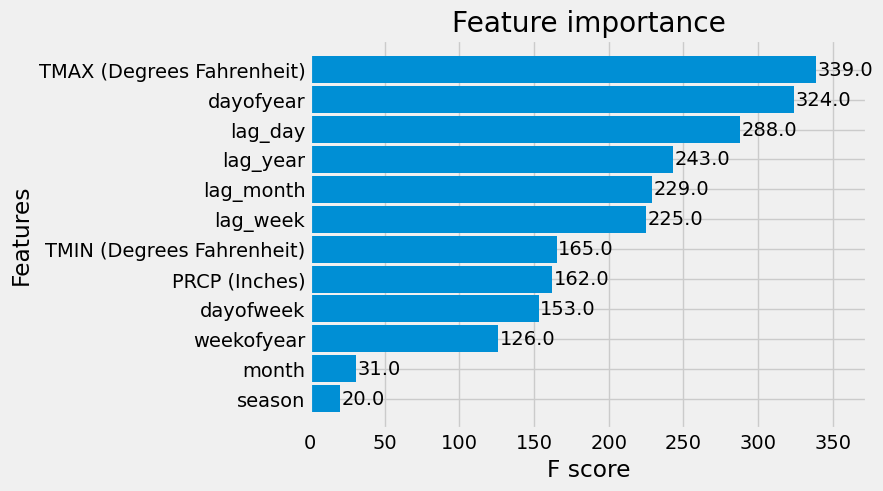

In [15]:
plot_importance(reg, height=0.9)
plt.show()

We can see that it was a good idea to include the weather data because it was the feature with the highest importance. Also, the different lag features seem to be a good choice. 'Month' and 'Season', however, seem to be of minor importance.

Now let's train the model one last time on the complete data set and save it afterwards.

In [16]:
X=data.iloc[:,1:].astype('float')
y=data.iloc[:,0].astype('float')


reg=xgb.XGBRegressor(**params, seed=20)


reg.fit(X, y, eval_set=[(X, y)],verbose=100)

[0]	validation_0-rmse:239.76501
[100]	validation_0-rmse:22.94292
[200]	validation_0-rmse:22.08270
[300]	validation_0-rmse:21.65254
[400]	validation_0-rmse:21.29928
[499]	validation_0-rmse:21.02996


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=20,
             reg_alpha=100, reg_lambda=1, ...)

In [17]:
reg.save_model('/Users/lutz/Documents/911_data/model/911_call_volumn_model_20221010.json')